# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [44]:
import numpy as np
import matplotlib.pyplot as plt  

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import inauguralproject
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

### **Method:**

The model is solved using the HouseholdSpecializationModelClass in the following way:

- Create an instance of the class with baseline parameters.<br><br>
- Use the method, ```calc_utility()```, to calculate all the possible utilities.<br><br>
- Use the method, ```solve_discrete()```, to maximize utility by findind the optimal level of $H_M, H_F, L_M, L_F$.<br><br>
- Do this for different values of $\alpha$ and $\sigma$.

### **Solution:**

**Allow for different values of $\sigma$ by adjusting the code in the function, calc_utility. Add the following under b:**

In [45]:
# if par.sigma == 0:
#             H = np.min(HM,HF)
#         elif par.sigma == 1:
#             H = HM**(1-par.alpha)*HF**par.alpha
#         else:
#             exponent = (par.sigma-1)/par.sigma
#             term1 = (1-par.alpha)*HM**exponent
#             term2 = par.alpha*HF**exponent
#             H = (term1 + term2)**(exponent**(-1))      

**Create instance of the model class:**

In [46]:
model = HouseholdSpecializationModelClass()

**Setup:**

In [47]:
# simplify syntax
par = model.par
sol = model.sol

# create lists of parameters
sigmas = [0.5, 1.0, 1.5]
alphas = [0.25, 0.5, 0.75]

**Run model:**

In [101]:
# create a empty lists to store output
frac_sigma = []
frac_alpha = []

# loop over alpha and sigma
for parameter_list, parameter_name, output_list in [(sigmas, 'sigma', frac_sigma), (alphas, 'alpha', frac_alpha)]:

    # reset baseline parameters
    par.sigma = 1.0
    par.alpha = 0.5

    # loop over different values
    for value in parameter_list:
        
        # set parameter value
        setattr(par, parameter_name, value)

        # save output and save to list
        print("Solution for " + str(parameter_name) + " = " + str(value) + ":")
        opt = model.solve_discrete(do_print=True)
        output_list.append(opt.HF/opt.HM)

Solution for sigma = 0.5:


/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:91: RuntimeWarning: invalid value encountered in reciprocal
  


LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for sigma = 1.0:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for sigma = 1.5:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for alpha = 0.25:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for alpha = 0.5:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for alpha = 0.75:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000


**Plot $\frac{H_F}{H_M}$ for different values of $\sigma$ and $\alpha$:** 

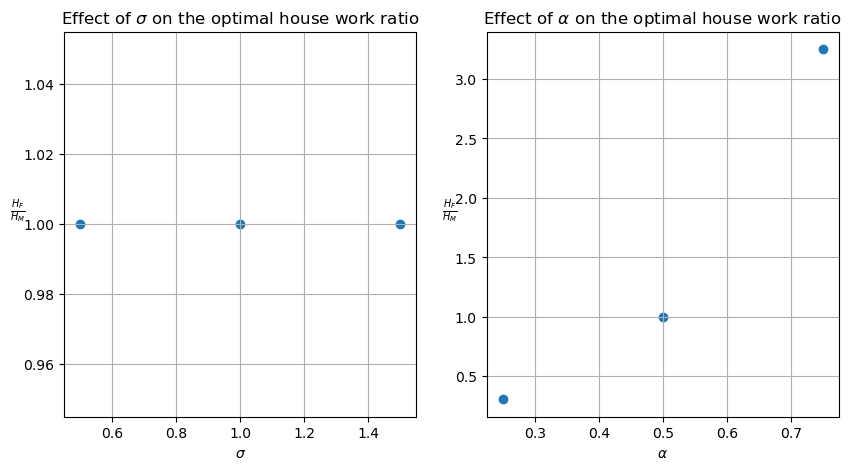

In [86]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(sigmas, frac_sigma)
ax2.scatter(alphas, frac_alpha)

# include a grid
ax1.grid(True)
ax2.grid(True)

# set the labels and title
ax1.set_xlabel(r'$\sigma$')
ax1.set_ylabel(r'$\frac{H_F}{H_M}$', rotation=0)
ax1.set_title(r'Effect of $\sigma$ on the optimal house work ratio')

ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel(r'$\frac{H_F}{H_M}$', rotation=0)
ax2.set_title(r'Effect of $\alpha$ on the optimal house work ratio')

# show the plot
plt.show()

It is evident that the house work ratio, $H_F/H_M$, does not change with the elasticity of substitution, $\sigma$. Each sex works the same amount, though a high elasticity of substitution allows them to change their relative workload and keep the same house production. 

This is because there is no incentive to do so. I.e. each sex is equally productive as $\alpha = 0.5$.

If we change $\alpha = 0.25$, the house work ratio decreasing as the elasticity of subsitution increases:

In [87]:
# create a empty lists to store output
frac_sigma = []
frac_alpha = []

# loop over alpha and sigma
for parameter_list, parameter_name, output_list in [(sigmas, 'sigma', frac_sigma), (alphas, 'alpha', frac_alpha)]:

    # reset baseline parameters
    par.sigma = 1.0
    par.alpha = 0.25

    # loop over different values
    for value in parameter_list:
        
        # set parameter value
        setattr(par, parameter_name, value)

        # save output and save to list
        print("Solution for " + str(parameter_name) + " = " + str(value) + ":")
        opt = model.solve_discrete(do_print=True)
        output_list.append(opt.HF/opt.HM)

Solution for sigma = 0.5:


/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:91: RuntimeWarning: invalid value encountered in reciprocal
  


LM = 3.0000
HM = 5.5000
LF = 6.0000
HF = 3.0000
Solution for sigma = 1.0:
LM = 2.0000
HM = 6.5000
LF = 7.0000
HF = 2.0000
Solution for sigma = 1.5:
LM = 1.5000
HM = 7.0000
LF = 7.0000
HF = 1.5000
Solution for alpha = 0.25:
LM = 2.0000
HM = 6.5000
LF = 7.0000
HF = 2.0000
Solution for alpha = 0.5:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for alpha = 0.75:
LM = 6.5000
HM = 2.0000
LF = 2.5000
HF = 6.5000


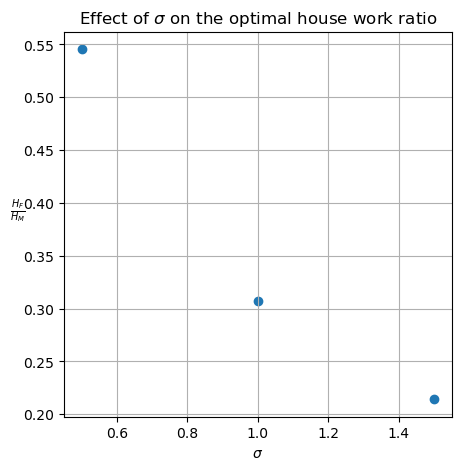

In [93]:
# plot the results
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

ax1.scatter(sigmas, frac_sigma)

# include a grid
ax1.grid(True)

# set the labels and title
ax1.set_xlabel(r'$\sigma$')
ax1.set_ylabel(r'$\frac{H_F}{H_M}$', rotation=0)
ax1.set_title(r'Effect of $\sigma$ on the optimal house work ratio')

# show the plot
plt.show()

# Question 2

Explain your code and procedure

In [103]:
# list of wages
wages = [0.8,0.9,1.0,1.1,1.2]

# base parameters
model.__init__()

In [104]:
# create a empty lists to store output
frac_wages = []

# loop over different wages
for value in wages:
        
    # set wage
    setattr(par, 'wF', value)

    # save output and save to list
    print("Solution for wF = " + str(value) + ":")
    opt = model.solve_discrete(do_print=True)
    frac_wages.append(opt.HF/opt.HM)    

Solution for wF = 0.8:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for wF = 0.9:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for wF = 1.0:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for wF = 1.1:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000
Solution for wF = 1.2:
LM = 4.5000
HM = 4.5000
LF = 4.5000
HF = 4.5000


In [106]:
# plot the results
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

ax1.scatter(wages, frac_wages)

# include a grid
ax1.grid(True)

# set the labels and title
ax1.set_xlabel(r'$w_F$')
ax1.set_ylabel(r'$\frac{H_F}{H_M}$', rotation=0)
ax1.set_title(r'Effect of $\w_F$ on the optimal house work ratio')

# show the plot
plt.show()

ValueError: 
\w_F
^
Unknown symbol: \w, found '\'  (at char 0), (line:1, col:1)

<Figure size 500x500 with 1 Axes>

# Question 3

Explain your code and procedure

In [4]:
# code

ADD CONCISE CONLUSION.